# Tarea 5
## Diferencias finitas y métodos iterativos

Autor: Emmanuel Alejandro Larralde Ortiz | emmanuel.larralde@cimat.mx

## Ejercicio 1
Desarrolle un programa el cual resuelva la ecuación de calor en 1D estacionaria. Determine el sistema utilizando el método de diferencias finitas y resuelva este con ayuda de la factorización Cholesky. Utilice la siguiente información para la ecuación $Q = 1000$, $K = 1$, $\Phi_0 = 0$, $\Phi_n = 100$, $L = 10$, $n \in \{4, 10, 30, 50, 70, 100\}$.

Graficar la temperatura en el nodo central para los distintos valores de $n$.

### Solución

El sistema de ecuaciones con $n$ elementos finitos contiene $n-1$ incógnitas y es representado con una matriz tridiagonal simétrica. El sistema de ecuaciones se expresa con la siguiente ecuación matricial.

\begin{equation}
    \begin{bmatrix}
    2 & -1 & 0 & \dots & 0 & 0 & 0\\
    -1 & 2 & -1 & \dots & 0 & 0 & 0\\
    0 & -1 & 2 & \dots & 0 & 0 & 0\\
    \vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots \\ 
    0 & 0 & 0 & \dots & -1 & 2 & -1 \\
    0 & 0 & 0 & \dots & 0 & -1 & 2 \\
    \end{bmatrix}
    \begin{bmatrix}
    \phi_1 \\
    \phi_2 \\
    \phi_3 \\
    \vdots \\
    \phi_{n-2} \\
    \phi_{n-1}
    \end{bmatrix}
    =
    \frac{1}{K}
    \begin{bmatrix}
    Q \Delta x^2 + \phi_0 K\\
    Q \Delta x^2 \\
    Q \Delta x^2 \\
    \vdots \\
    Q \Delta x^2 \\
    Q \Delta x^2 + \phi_n K\\
    \end{bmatrix}
\end{equation}

Con $\Delta x = \frac{L}{n}$

Para resolver el problema, copié el código que usé en la tarea anterior en el ejercicio de factorización de [Cholesky simple](https://github.com/L4rralde/matrix_decomposition/blob/main/src/cholesky.c) ($A = LL^T$) y reemplacé la lectura de la matriz y vector con un código para crear la matriz y el vector según la ecuación de arriba. Los valores $Q$, $K$, $\phi_0$, $\phi_n$, $L$ y $n$ son argumentos de entrada del código principal.

El programa principal es `src/heat.c`. A continuación se muestra el código que crea la matriz y el vector.

```C
//heat.c

int nxs = n-1; //Number of unknowns.
double dx, bi;
dx = L/((double) n); //size of the finite element.
bi = (Q * dx*dx)/K; //Qdx^2/K

double *mat, *b;
//Knowns vector init.
b = (double *) malloc(nxs * sizeof(double));
for(int i=0; i<nxs; ++i)
    *(b + i) = bi;
*b += phi_0;
*(b + nxs - 1) += phi_n;

//Matrix initialization.
mat = (double *) malloc(nxs * nxs * sizeof(double));
for(int i=0; i<nxs; ++i)
    *(mat + i*nxs + i) = 2; //Diagonal elements.
for(int i=0; i<nxs-1; ++i)
    *(mat + i*nxs + i + 1) = -1; //Above diagonal.
for(int i=1; i<nxs; ++i)
    *(mat + i*nxs + i - 1) = -1; //Below diagonal.
```

In [1]:
import os

if not os.path.exists("output"):
    os.makedirs("output")

In [16]:
#Compilacion
!gcc src/heat.c include/matrices/matrices.c -o output/heat.o -lm
!chmod +x output/heat.o

### Tests

4 elementos

In [3]:
!./output/heat.o 1000 1 0 100 10 4

Error = norm(flatten(mat), flatten(LL')): 0.000000
x: 9400.000000 12550.000000 9450.000000 
Error = norm(b, b'): 0.000000
Answer:
4,12550.000000


4, 10, 30, 50, 70 y 100 elementos

In [4]:
%%bash
echo "n,value" > samples/output/heat.csv
for n in 2 4 10 30 50 70 100
do
    ./output/heat.o 1000 1 0 100 10 $n | grep Answer -A 1 | grep , >> samples/output/heat.csv
done
cat samples/output/heat.csv

n,value
2,12550.000000
4,12550.000000
10,12550.000000
30,12550.000000
50,12550.000000
70,12550.000000
100,12550.000000


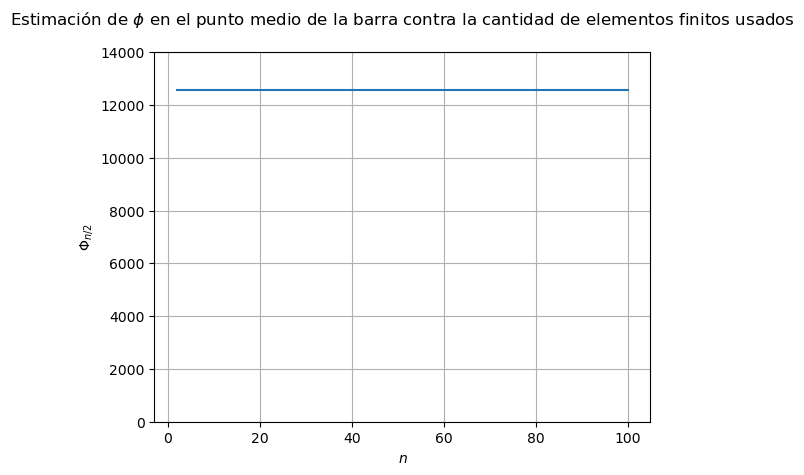

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("samples/output/heat.csv")
plt.title("Estimación de $\phi$ en el punto medio de la barra contra la cantidad de elementos finitos usados\n")
plt.plot(df['n'], df['value'])
plt.ylim(0, 14000)
plt.grid()
plt.xlabel("$n$")
plt.ylabel("$\Phi_{n/2}$")
plt.show()

Como observamos, dos elementos finitos son suficientes para encontrar el valor de $\Phi$ en el punto medio de la barra. De hecho, $12,250$ es la solución correcta obtenida al resolver la ecuación diferencial y evaluar en el punto medio.

Aumentar la cantidad de elementos nos ayuda a obtener el valor de $\Phi$ en diferentes puntos de la barra y ver cómo es la solución analítica (tiene forma cuadrática)

In [6]:
import numpy as np

def plot_heat(n):
    with open("samples/output/heat_bar.txt", 'r') as f:
        line = f.read().splitlines()[0]
    x = np.linspace(0, 10, n+1)
    heats = np.array([0.0] + [float(h) for h in line.split()[1:]] + [100.0])

    fig, (ax,ax2) = plt.subplots(nrows=2, sharex=True)
    fig.suptitle(f"Solución de la ecuación de calor con {n} elementos")


    extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
    ax.imshow(heats[np.newaxis,:], cmap="plasma", aspect="auto", extent=extent)
    ax.set_yticks([])
    ax.set_xlim(extent[0], extent[1])

    ax2.plot(x,heats)
    ax2.set_ylabel("$\phi$")
    ax2.set_xlabel("$x$")
    ax2.grid()

    plt.tight_layout()
    plt.show()

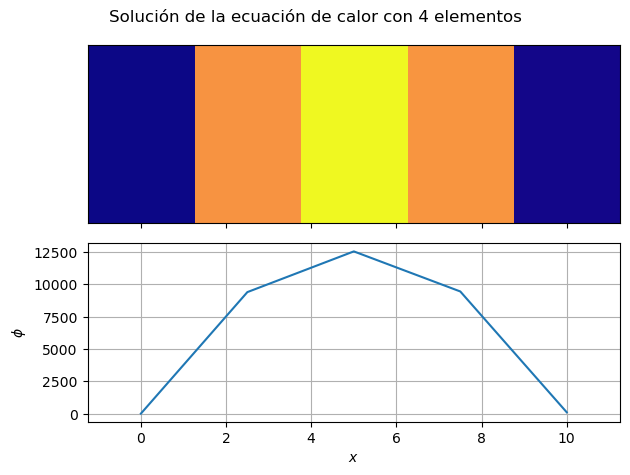

In [7]:
n = 4
os.environ['n'] = str(n)
!./output/heat.o 1000 1 0 100 10 $n | grep x > samples/output/heat_bar.txt

plot_heat(n)

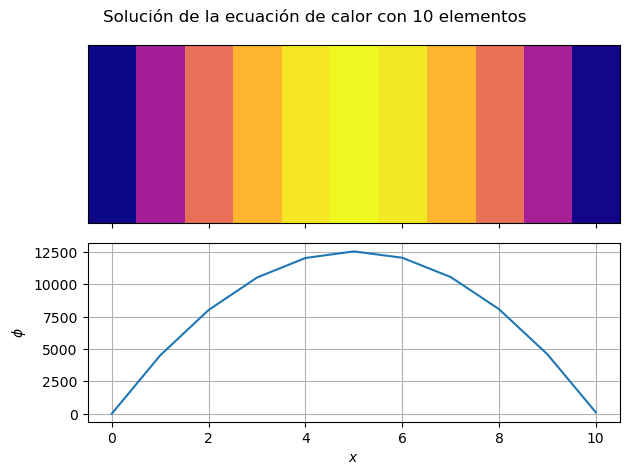

In [8]:
n = 10
os.environ['n'] = str(n)
!./output/heat.o 1000 1 0 100 10 $n | grep x > samples/output/heat_bar.txt

plot_heat(n)

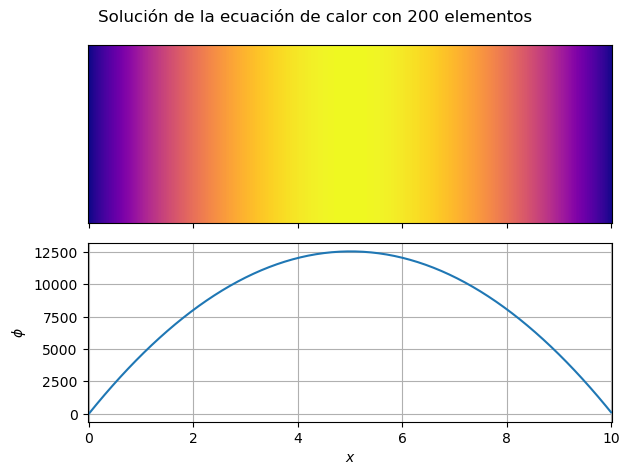

In [9]:
n = 200
os.environ['n'] = str(n)
!./output/heat.o 1000 1 0 100 10 $n | grep x > samples/output/heat_bar.txt

plot_heat(n)

### Ejercicio 2

Desarrolle un programa que resuelva un sistema de ecuaciones de la forma $Ax = b$ utilizando el método de `Jacobi`.

### Solución

El método de Jacobi involucra realizar la siguiente operación de forma iterativa hasta que converja a un valor:

$$x_i^+ = \frac{b_i - \sum_{j=1, j\neq i}^n A_{ij} x_j^-}{A_{ii}}$$

Donde $x$ lo inicializo con un vector de ceros.

Dado a que los métodos de `Jacobi` y `Gauss-Seidel` son casi idénticos, usé una sola función para implementar ambas funciones. Como uso punteros para acceder a los elementos de $x$, basta con modificar el puntero con el que se hace la operación de suma.

El código se encuentra en `include/matrices/matrices.c`

```C
//matrices.c

//Realiza el metodo de Gauss-Seidel usando los valores de xs mas recientes 
//o de la estimacion anterior
double *_gauss_seidel(double *mat, double *b, int n, int no_stale){
    double *x;
    x = (double *) calloc(n, sizeof(double));
    //Safeguard: non-0s check
    for(int i=0; i<n; ++i){
        if(*(mat + i*n + i) == 0){
            printf("EXCEPTION: found zeros in diagonal\n");
            return x;
        }
    }
    double *prev_x, *xptr, acc, error;
    prev_x = (double *) calloc(n, sizeof(double));
    //if no_stale==1:
    //  Usa los valores más recientes de x
    //else:
    //  Usa los valores de la iteración anterior.
    xptr = (no_stale == 1)? x: prev_x;
    for(int rep=0; rep<2000; rep++){
        copy_matrix_no_alloc(x, prev_x, 1, n);
        for(int i=0; i<n; ++i){//Para cada elemento de x.
            acc = 0;
            for(int j=0; j<n; ++j){//Para cada elemento de x...
                if(i==j) //Excepto xi (o sea, el mismo elemento de x)
                    continue;
                acc += (*(mat + i*n + j)) * (*(xptr + j)); //mat[i][j]*mat[j]
            }
            //x[i] = (b[i] - acc)/(mat[i][i])
            *(x + i) = (*(b + i) - acc)/(*(mat + i*n +i));
        }
        //Calcula la distancia entre la iteración actual y la anterior
        error = norm(x, prev_x, n); 
        if(error <= 0.0001) //Si no cambia mucho, termina.
            break;
    }
    if(error > 0.0001)
        printf("WARNING: Couldn't find a solution\n");

    free(prev_x);
    return x;
}
```

Pero la función que se termina usando en el código principal es la siguiente
```C
//matrices.c

//Obtiene la solucion de Ax=b usando el método de Jacobi
double *jacobi(double *mat, double *b, int n){
    return _gauss_seidel(mat, b, n, 0);
}
```

El código principal es `src/jacobi.c` y tiene la misma estructura que los códigos de resolución de sistemas de ecuaciones anteriores, es decir,
1. Lee Matriz
2. Lee vector.
3. Resuelve matriz.
4. Comprueba la solcuión con $Ax_{sol} = b$

In [10]:
#Compilacion
!gcc src/jacobi.c include/matrices/matrices.c -o output/jacobi.o -lm
!chmod +x output/jacobi.o

#### Tests

In [11]:
#Small
!./output/jacobi.o samples/input/SmallMatrix.txt samples/input/SmallVector.txt

Solucion: 0.239960 1.035789 -1.916582 
b': 0.999619 7.849495 -19.300994 
b (original): 1.000000 7.850000 -19.300000 
Error = norm(b - b'): 0.000001


In [12]:
#Big
!./output/jacobi.o samples/input/BigMatrix.txt samples/input/BigVector.txt

Solucion: 34371.674726 9715.934660 0.000003 19833.027114 15233.777153 12475.448139 9001.236051 6685.904074 0.000000 3145.632339 10521.456996 1421.894085 24463.627675 1958.533315 18248.013354 12015.123571 7788.217642 4383.011375 13750.731477 7544.349061 842.850576 12407.228158 4815.028385 9813.231733 0.000000 2699.661054 23226.872137 8664.582339 10729.727285 2879.914895 19010.913514 11422.159277 0.000003 15362.987773 10422.556392 11801.314576 2229.237869 1526.854276 3937.542143 9766.044183 5129.995292 7486.640264 17219.886916 14705.746505 1436.724472 2140.840799 3459.032112 2869.943620 4281.211161 3639.684696 5762.018171 6236.435287 12770.627259 10596.269528 10608.262039 12846.046642 14714.642952 6007.193372 8418.107159 9027.562261 6955.013205 8901.836544 8368.554130 0.000003 0.006738 7784.898406 6695.733380 5598.740041 4670.232837 4238.565361 3821.005575 3034.567215 1878.671134 744.031783 7188.920748 0.000003 0.006738 2683.600761 2434.740815 0.000000 6658.889458 665.617898 373.656495 2

### Ejercicio 3

Desarrolle un programa que resuelva un sistema de ecuaciones de la forma $Ax = b$ utilizando el método de `Gauss-Seidel`.

### Solución

Como se mencionó anteriormente, la única diferencia con el método de `Jacobi` es que se utilizan los datos más recientes, es decir,

$$x_i = \frac{b_i - \sum_{j=1, j\neq i}^n A_{ij} x_j}{A_{ii}}$$


La función utilizada se encuentra en `include/matrices/matrices.c`.

```C
//matrices.c

//Obtiene la solucion de Ax=b usando el método de Gauss-Seidel
double *gauss_seidel(double *mat, double *b, int n){
    return _gauss_seidel(mat, b, n, 1);
}
```

Y el programa principal es `src/gauss_seidel.c`

In [13]:
# Compilacion
!gcc src/gauss_seidel.c include/matrices/matrices.c -o output/gauss_seidel.o -lm
!chmod +x output/gauss_seidel.o

In [14]:
!./output/gauss_seidel.o samples/input/SmallMatrix.txt samples/input/SmallVector.txt

Solucion: 0.240088 1.035860 -1.916485 
b': 0.999975 7.849976 -19.300000 
b (original): 1.000000 7.850000 -19.300000 
Error = norm(b - b'): 0.000000


In [15]:
!./output/gauss_seidel.o samples/input/BigMatrix.txt samples/input/BigVector.txt

Solucion: 34371.785514 9716.032815 0.000003 19833.137321 15233.885704 12475.553855 9001.328387 6685.978402 0.000000 3145.670773 10521.558129 1421.910261 24463.738764 1958.557777 18248.120461 12015.219777 7788.293102 4383.058841 13750.839309 7544.428362 842.860606 12407.330653 4815.082025 9813.329869 0.000000 2699.693226 23226.982541 8664.663856 10729.820849 2879.947755 19011.023130 11422.263452 0.000003 15363.092888 10422.654183 11801.419069 2229.263322 1526.872100 3937.588456 9766.131756 5130.050084 7486.716555 17219.997178 14705.853951 1436.742026 2140.866132 3459.072199 2869.975984 4281.258831 3639.725437 5762.079628 6236.503921 12770.729124 10596.365762 10608.354102 12846.146836 14714.746708 6007.255720 8418.194516 9027.649787 6955.083562 8901.921383 8368.646527 0.000003 0.006738 7784.987702 6695.813306 5598.814107 4670.297840 4238.619416 3821.060961 3034.612079 1878.699737 744.043148 7189.006626 0.000003 0.006738 2683.640433 2434.774229 0.000000 6658.971846 665.626817 373.662217 2